# Fichier pour récolter les données Spotify grâce à son API (spotipy sur Python)

## Importer les librairies

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: okabeshu
"""
import pandas as pd
import sys
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

## Configurer l'accès à Spotify

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Identifiants
client_id = "a13a7e52ed5542ceb7e37cb64b55fbf0"
client_secret = "396a16805f1f4bc1912a93f4069a24ea"
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)

# Accéder à Spotify
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## Récolter les données sur les playlists
### Lister toutes les playlists Spotify officielles avec le nom, le nombre de followers et le lien interne Spotify de chaque playlist

In [5]:
# Accéder aux différentes playlists Spotify officielles
user = "spotify"

# Créer un DataFrame de l'ensemble des playlists Spotify officielles
def lister_tout (user) :
    playlist = []
    total = sp.user_playlists(user, limit = 1)["total"] # Nombre total de playlists
    for i in range (total) : # 1694 playlists
        try :
            dic = sp.user_playlists(user, limit = 1, offset = i) # Méthode pour ne pas être limité dans l'extraction
            items = dic["items"][0] # Informations sur la playlist
            uri = items["uri"] # Lien Spotify pour la playlist
            follow = sp.user_playlist(user, uri)["followers"]["total"] # Nombre de followers
            playlist += [{"playlist_name" : items["name"], "uri_pl" : uri, "followers" : follow}]
        except :
            pass
        #print(i)
    df_playlist = pd.DataFrame(playlist)
    return df_playlist

# Liste (DataFrame) des playlists Spotify ; il n'en reste plus que 1631.
#liste = lister_tout(user)

# Enregistrer le DataFrame pour une utilisation ultérieure (liste du 30/12/2017)
#liste.to_csv(path_or_buf = "/Users/okabeshu/Documents/ENSAE/Python DS/playlists.csv", encoding = "utf-8", index = False)

# Lire le DataFrame pour traiter les données
playlists_tout = pd.read_csv("/Users/okabeshu/Documents/ENSAE/Python DS/playlists.csv", encoding = "utf-8")

### Étudier la "popularité" des playlists à travers le nombre de followers

In [6]:
followers = playlists_tout["followers"]
followers.describe()

count    1.631000e+03
mean     2.198794e+05
std      6.948959e+05
min      0.000000e+00
25%      2.051500e+03
50%      3.281600e+04
75%      1.722820e+05
max      1.851960e+07
Name: followers, dtype: float64

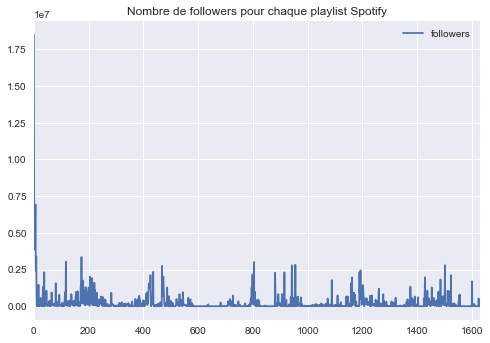

In [7]:
# Nombre de followers pour chacune des 1631 playlists.
followers.plot(legend = True, title = "Nombre de followers pour chaque playlist Spotify")

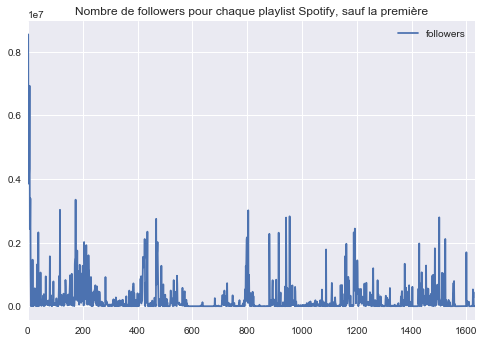

In [8]:
# On supprime la première playlist qui comptabilise 18519599 followers.
follower = followers.iloc[1:]
follower.plot(legend = True, title = "Nombre de followers pour chaque playlist Spotify, sauf la première")

In [9]:
# On supprime les huit premières playlists (Today's Top Hits, RapCaviar, ...)
follow = followers.iloc[7:]
follow.describe()

count    1.624000e+03
mean     1.894998e+05
std      4.093577e+05
min      0.000000e+00
25%      1.987500e+03
50%      3.226650e+04
75%      1.694210e+05
max      3.390430e+06
Name: followers, dtype: float64

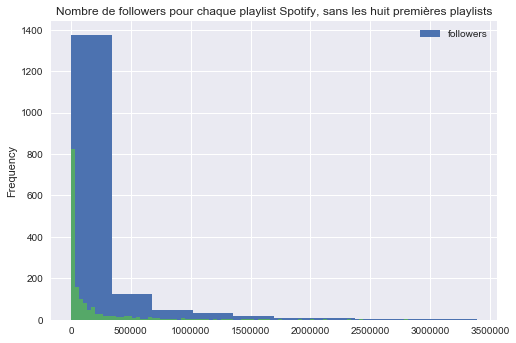

In [10]:
follow.plot(kind = "hist", legend = True, title = "Nombre de followers pour chaque playlist Spotify, sans les huit premières playlists")
follow.hist(bins = 100)

#### On observe qu'il y a beaucoup de playlists avec très peu de followers. On va donc les supprimer.

In [30]:
# Supprimer les playlists avec trop peu de followers (moins de n)
def filtrer_follow (playlists, n) :
    df = playlists[playlists["followers"] >= n]
    return df

# Garder que les playlists avec plus de 100 followers
playlists_t = filtrer_follow(playlists_tout, 100)   

followers_t = playlists_t["followers"]
follow_t = followers_t.iloc[7:]
follow_t.describe()

count    1.480000e+03
mean     2.079342e+05
std      4.243279e+05
min      1.020000e+02
25%      5.952500e+03
50%      4.399250e+04
75%      1.884020e+05
max      3.390430e+06
Name: followers, dtype: float64

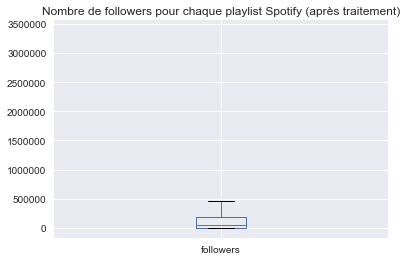

In [34]:
follow_t.plot(kind = "box", legend = True, title = "Nombre de followers pour chaque playlist Spotify (après traitement)")
#follow_t.hist(bins = 100)

In [35]:
# Garder que les playlists avec plus de 300000 followers
playlists_t = filtrer_follow(playlists_tout, 300000)   

followers_t = playlists_t["followers"]
follow_t = followers_t.iloc[7:]
follow_t.describe()

count    2.720000e+02
mean     8.797929e+05
std      6.361696e+05
min      3.007110e+05
25%      4.377798e+05
50%      6.361035e+05
75%      1.106463e+06
max      3.390430e+06
Name: followers, dtype: float64

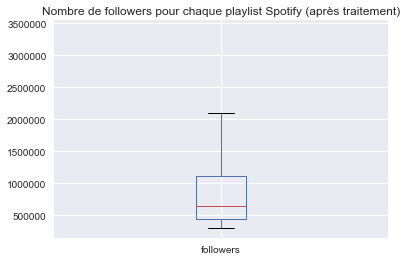

In [38]:
follow_t.plot(kind = "box", legend = True, title = "Nombre de followers pour chaque playlist Spotify (après traitement)")

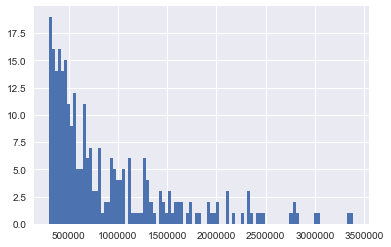

In [39]:
follow_t.hist(bins = 100)

In [46]:
# DataFrame avec les playlists choisies
playlists = playlists_t.drop("followers", axis = 1)

## Récolter les chansons des playlists choisies

In [ ]:
# Créer un tableau contenant les informations sur les chansons d'une playlist en France
def info_base_playlist (user, id_playlist, name_playlist) :
    # Récupérer les données d'une playlist
    playlist = sp.user_playlist_tracks(user, playlist_id = id_playlist, limit = 100, offset = 0, fields = None, market = "FR")
    total = playlist["total"]  # Nombre de chansons
    info_songs = playlist["items"] # Chansons
    #print(total)
    # Traiter les informations sur les chansons
    songs = []
    for X in info_songs : 
        info = X["track"]
        artist = info["artists"][0]["name"] # Nom de l'artiste
        name = info["name"] # Titre de la chanson
        pop = info["popularity"] # La popularité de la chanson
        uri = info["uri"] # L'identifiant de la chanson
        features = sp.audio_features(uri)[0] # Informations sur la chanson
        dico = {"artist" : artist, "title" : name, "popularity" : pop, "playlist_name" : name_playlist}
        dico.update(features)
        songs += [dico] # Juste les informations nécessaires
    # Données en DataFrame
    df = pd.DataFrame(songs) # Transformer en DataFrame
    df = df.drop(["analysis_url", "track_href", "type", "id"], axis = 1) # Supprimer les colonnes inutiles
    return df
    
# Exemple : Chansons dans la playlist Joyeux Noël !
#noel = "spotify:user:spotify:playlist:37i9dQZF1DX0QqahDuqmRY"
#songs = info_base_playlist (user, noel, "Joyeux Noël !")
# Enregistrer le fichier
#songs.to_csv(path_or_buf = "/Users/okabeshu/Documents/ENSAE/Python DS/test.csv", encoding = "utf-8", index = False)
# Lire le fichier
#test = pd.read_csv("/Users/okabeshu/Documents/ENSAE/Python DS/test.csv", encoding = "utf-8")

In [47]:
# Collecter les données des playlists Spotify choisies
def create_data (user, playlist) : 
    df = pd.DataFrame() # DataFrame à remplir
    for i in range (len(playlist)) : # Boucle for pour pouvoir savoir l'avancement de la fonction
        ligne = playlist.iloc[i]
        nom, id_playlist = ligne["playlist_name"], ligne["uri_pl"]
        print("name", nom, "id", id_playlist)
        try : 
            info = info_base_playlist (user, id_playlist, nom) # Récolter les informations sur la playlist
            df = df.append(info, ignore_index = True) # Ajout de la ligne
        except :
            pass
        print(i)
    return df

# DataFrame avec les informations sur les chansons des playlists Spotify avec plus de 300000 followers.
#data = create_data(user, playlists)

In [48]:
# Enregistrer le fichier
#data.to_csv(path_or_buf = "/Users/okabeshu/Documents/ENSAE/Python DS/Spotify.csv", encoding = "utf-8", index = False)
# Lire le fichier
#donnees = pd.read_csv("/Users/okabeshu/Documents/ENSAE/Python DS/Spotify.csv", float_precision = "high", encoding = "utf-8")